In [1]:
import os
import keras
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import src.features.build_features as build_features
from src.models.train_model import MonteCarloDropout, MCLSTM

# Load the Models

In [2]:
load_path = r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\models\wandb_models"

merged_model = keras.models.load_model(os.path.join(load_path, "merged-ce.h5"), 
                                       custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})

FNN_model = keras.models.load_model(os.path.join(load_path, "FNN-ce.h5"), 
                                       custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})

RNN_model = keras.models.load_model(os.path.join(load_path, "RNN-ce.h5"), 
                                       custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})

merged_model_mc = keras.models.load_model(os.path.join(load_path, "merged-ce-mc.h5"), 
                                       custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})

FNN_model_mc = keras.models.load_model(os.path.join(load_path, "FNN-ce-mc.h5"), 
                                       custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})

RNN_model_mc = keras.models.load_model(os.path.join(load_path, "RNN-ce-mc.h5"), 
                                       custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})

# Load Test Data

In [3]:
data = build_features.load_preprocessed_data(use_all_data=True)

In [29]:
test_size = 1000

event_X_test = data['event_X_test'].iloc[:test_size]
object_X_test = data['object_X_test'][:test_size]
y_test = data['y_test'].iloc[:test_size]

models = [(merged_model, [event_X_test, object_X_test], 'Merged Model'), (FNN_model, event_X_test, 'FNN Model'), (RNN_model, object_X_test, 'RNN Model')]
mc_models = [(merged_model_mc, [event_X_test, object_X_test], 'Merged Model'), (FNN_model_mc, event_X_test, 'FNN Model'), (RNN_model_mc, object_X_test, 'RNN Model')]

# Make Predictions

In [5]:
# Goes through each model and gets the mean prediction of n_samples predictions of the test set, then repeats n_preds times

n_preds = 10 # number of times to predict the test set
n_samples = 10 # number of models to sample from
auc_dicts = []

def mc_predict(X, model, n_models):
    preds = [model.predict(X).ravel() for _ in range(n_models)]
    return np.mean(preds, axis=0)

for model, X_test, model_name in tqdm(mc_models):
    for i in tqdm(range(n_preds)):
        preds = mc_predict(X_test, model, n_samples)
        auc_score = roc_auc_score(y_test, preds)
        auc_dicts.append({'model': model_name, 'ROC AUC': auc_score})

baseline_preds = merged_model.predict([event_X_test, object_X_test])
baseline_auc = roc_auc_score(y_test, baseline_preds)

auc_df = pd.DataFrame.from_records(auc_dicts)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

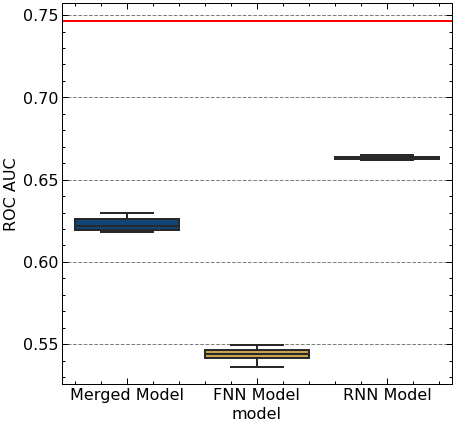

In [6]:
with plt.style.context(['science', 'grid', 'notebook', 'high-contrast']):
    plt.figure(figsize=(7, 7))
    sns.boxplot(x="model", y="ROC AUC", data=auc_df)
    plt.axhline(y=baseline_auc, color='r', linestyle='-')
    plt.show()

In [8]:
baseline_preds2 = merged_model.predict([data['event_X_test'], data['object_X_test']])
baseline_auc2 = roc_auc_score(data['y_test'], baseline_preds2)
baseline_auc2

0.7431921141240039

In [12]:
baseline_preds3 = merged_model.predict([data['event_X_train'], data['object_X_train']])
baseline_auc3 = roc_auc_score(data['y_train'], baseline_preds3)
baseline_auc3

0.7417824062673131

In [24]:
post_op_model = keras.models.load_model(r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\models\post_optuna_model.h5", 
                                       custom_objects={'MonteCarloDropout': MonteCarloDropout, "f1_score": 0})

In [25]:
baseline_preds4 = post_op_model.predict([data['event_X_test'], data['object_X_test']])
baseline_auc4 = roc_auc_score(data['y_test'], baseline_preds4)
baseline_auc4

0.6791062136945283

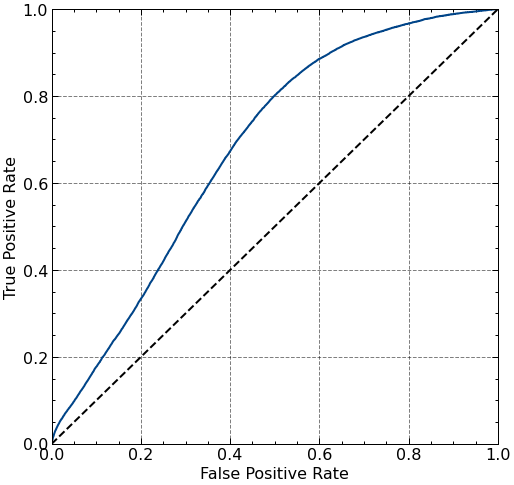

In [35]:
import src.visualization.visualize as vis

vis.make_roc_curve(data, baseline_preds4)

(array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
        0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
        0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
        0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
        0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
        0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
        0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
        0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
        0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
        0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ]),
 array([4.72305831, 4.72305831, 4.72305831, 4.72305831, 4.72305831,
        4.72305831, 4.72305831, 4.72305831, 4.72305831, 4.72305831,
        4.72305831, 4.72305831, 4.72305831, 4.72305831, 4.72305831,
        4.72305831, 4.72305831, 4.72305831, 4.72305831, 4.72305831,
        4.72305831, 4.72305831, 4.72305831, 4.

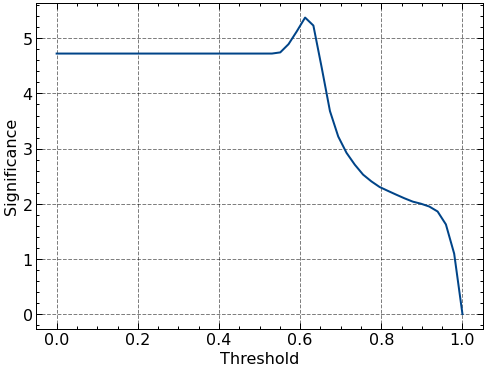

In [37]:
vis.make_significance(data, baseline_preds4)